In [ ]:
import os
os.chdir(os.path.join(os.getcwd(), "../code"))
import numpy as np
from parameters import Params
from simulation import Simulation
import matplotlib.pyplot as plt
from agent import ReservoirAgent, BrownianAgent, LévyAgent
from environment import Environment

tolerance = 0.02

params = Params.from_json('parameters.json')
data = []
environment = Environment(params)

params.type = 'reservoir'
params.agent = ReservoirAgent
sim = Simulation(params, params.agent)
population = sim.run_epoch(sim.set_up_population(None), environment)
step_lengths = np.array([])
for agent in population:
    step_counter = 0
    for output in agent.output_log:
        if abs(output) > 1 - tolerance or abs(output) < tolerance:
            step_counter += 1
        else:
            step_lengths = np.append(step_lengths, step_counter)
            step_counter = 1
data.append(step_lengths)

# not implemented yet
# params.type = 'brownian'
# params.agent = BrownianAgent
# sim = Simulation(params, params.agent)
# sim.run('step_length_study/brownian')

params.type = 'levy'
params.agent = LévyAgent
sim = Simulation(params, params.agent)
population = sim.run_epoch(sim.set_up_population(None), environment)
step_lengths = np.array([])
for agent in population:
    step_lengths = np.concatenate((step_lengths, agent.step_length_log))
data.append(step_lengths)


100%|██████████| 5/5 [01:21<00:00, 16.25s/it]


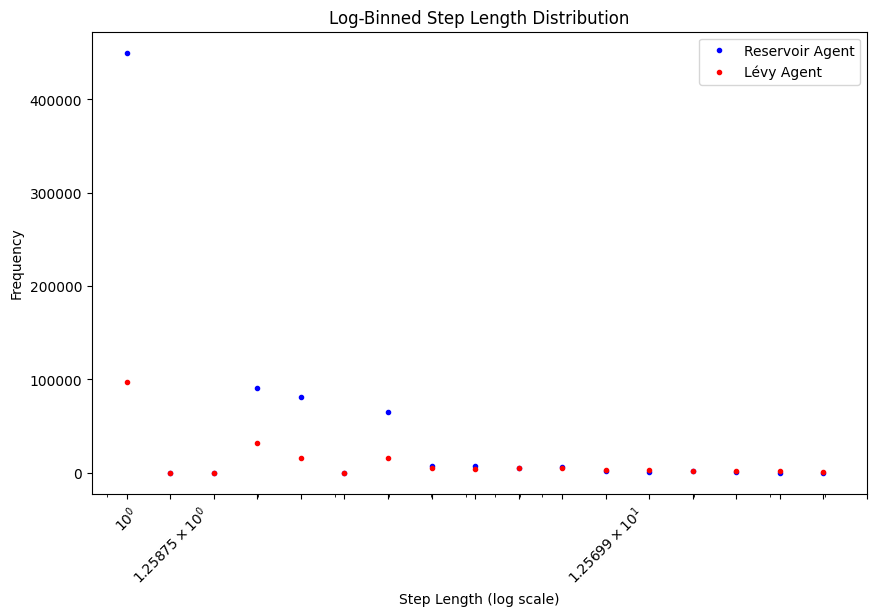

In [9]:
bins = 18
log_bins = np.logspace(np.log10(1), np.log10(50), bins)
log_counts_1, _ = np.histogram(data[0], bins=log_bins)
log_counts_2, _ = np.histogram(data[1], bins=log_bins)
plt.figure(figsize=(10, 6))
plt.plot(log_bins[:bins-1], log_counts_1, '.', color='blue', label='Reservoir Agent')
plt.plot(log_bins[:bins-1], log_counts_2, '.', color='red', label='Lévy Agent')
plt.xscale('log')
plt.title(f'Log-Binned Step Length Distribution')
plt.xlabel('Step Length (log scale)')
plt.ylabel('Frequency')
plt.xticks(log_bins, rotation=45)
plt.legend()
plt.show()